In [141]:
import preprocessFERplus as preprocess
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [224]:
data = preprocess.FERdata(
    'challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'
)

reading csvfile from challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv


In [225]:
# result = data.get_df(mode='GNN',
#                      sample=True,
#                      sample_size=100,
#                      drawlandmarks=True,
#                      with_img=True)

result = data.get_df(mode='GNN',
                     drawlandmarks=True,
                     with_img=True)

Generate df with config
 mode:GNN
 drawlandmarks:True
 mapping:False
 colormap:GRAY
 sample:False
 sample_size:35887
Prepare data to img


100%|██████████| 35887/35887 [00:23<00:00, 1510.93it/s]


Getting landmarks with mediapipe FaceMesh


100%|██████████| 35887/35887 [08:30<00:00, 70.27it/s]

Distribution of Train: 
3    6949
6    4820
4    4320
2    3692
0    3561
5    3015
1     378
Name: target, dtype: int64
Distribution of Validation: 
3    866
6    586
4    569
2    459
0    419
5    390
1     51
Name: target, dtype: int64
Distribution of Test 
3    851
6    596
4    538
2    487
0    434
5    393
1     48
Name: target, dtype: int64


In [226]:
result.head(10)

,usage,feature,target,edge_index,draw_img,img
0,train,"[[0.4375227093696594, 0.706290602684021, -0.09...",0,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[196, 196, 196], [196, 196, 196], [198, 198,...","[[196, 196, 198, 203, 154, 115, 116, 114, 114,..."
1,train,"[[0.4912356734275818, 0.7806726098060608, -0.0...",6,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[13, 13, 13], [11, 11, 11], [11, 11, 11], [9...","[[13, 11, 11, 9, 9, 9, 9, 4, 16, 50, 45, 39, 4..."
2,val,"[[0.35966402292251587, 0.7387071847915649, -0....",4,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[54, 54, 54], [53, 53, 53], [39, 39, 39], [3...","[[54, 53, 39, 30, 29, 65, 60, 14, 10, 101, 129..."
3,train,"[[0.42403459548950195, 0.7969208359718323, -0....",0,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[89, 89, 89], [89, 89, 89], [89, 89, 89], [8...","[[89, 89, 89, 86, 88, 76, 81, 188, 191, 212, 2..."
4,train,"[[0.49050790071487427, 0.7862312197685242, -0....",4,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[99, 99, 99], [96, 96, 96], [86, 86, 86], [8...","[[99, 96, 86, 80, 72, 69, 69, 57, 63, 57, 57, ..."
5,train,"[[0.4405638575553894, 0.7339315414428711, -0.0...",4,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[132, 132, 132], [142, 142, 142], [99, 99, 9...","[[132, 142, 99, 77, 59, 48, 67, 68, 60, 68, 10..."
6,train,"[[0.4904562532901764, 0.7978222370147705, -0.0...",4,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[16, 16, 16], [24, 24, 24], [22, 22, 22], [2...","[[16, 24, 22, 27, 36, 43, 42, 39, 38, 37, 38, ..."
7,train,"[[0.43134191632270813, 0.7784069180488586, -0....",2,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[163, 163, 163], [160, 160, 160], [154, 154,...","[[163, 160, 154, 159, 170, 180, 172, 157, 147,..."
8,train,"[[0.4494420289993286, 0.6928067207336426, -0.0...",3,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[255, 255, 255, 255, 255, 253, 255, 181, 90, ..."
9,train,"[[0.4244033992290497, 0.8428828716278076, -0.0...",0,"[(18, 17), (82, 38), (8, 9), (456, 248), (167,...","[[[101, 101, 101], [99, 99, 99], [98, 98, 98],...","[[101, 99, 98, 83, 39, 26, 21, 24, 31, 146, 20..."


In [227]:
FERclassName = [
    'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'
]


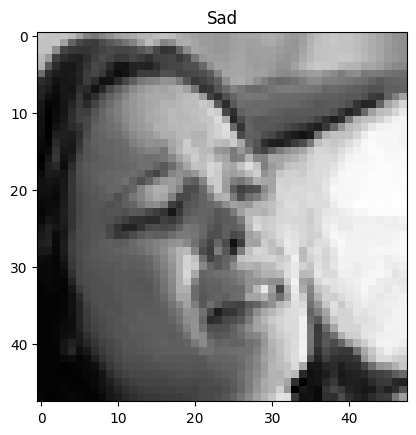

In [232]:
sample = result.iloc[60]
label = FERclassName[sample['target']]
img = sample['img']
plt.title(label)
plt.imshow(img, cmap='gray')

In [233]:
mesh_img = sample['draw_img']

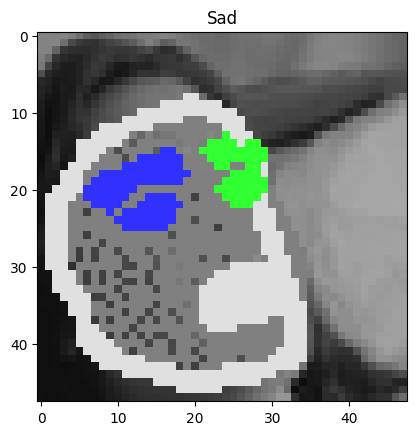

In [234]:
plt.title(label)
plt.imshow(mesh_img)

In [235]:
mesh = sample['feature']

In [236]:
mesh = np.array(mesh).reshape(478, 3)


In [237]:
def plot3dmesh(mesh):
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(mesh[:, 0],
                    mesh[:, 1],
                    mesh[:, 2],
                    cmap='viridis',
                    edgecolor='none')
    ax.view_init(270, 180, 90)
    ax.set(title=label, xlabel='X', ylabel='Y', zlabel='Z')


In [238]:
def re_pos(mesh):
    # print(f'shift from: {mesh[1]}')
    origin = mesh[1] - np.array([0, 0, 0])
    mesh = mesh - origin
    return mesh

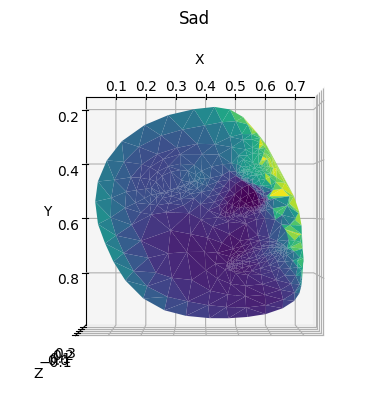

In [239]:
plot3dmesh(mesh)

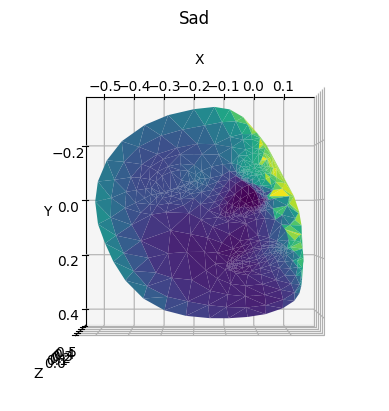

In [240]:
plot3dmesh(re_pos(mesh))

[Text(0.5, 0.92, 'Sad'),
 Text(0.5, 0, 'X'),
 Text(0.5, 0.5, 'Y'),
 Text(0.5, 0, 'Z')]

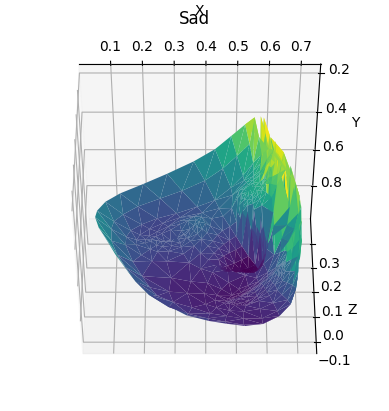

In [241]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_trisurf(mesh[:, 0],
                mesh[:, 1],
                mesh[:, 2],
                cmap='viridis',
                edgecolor='none')
ax.view_init(320, 270, 0)
ax.set(title=label, xlabel='X', ylabel='Y', zlabel='Z')


In [242]:
def quiver_plot(ax,origin,u,v,w,u_color='Red', v_color='Blue', w_color='Green',dash=False):
    ax.quiver(origin[0],origin[1],origin[2],u[0],u[1],u[2],length=0.3,color=u_color,normalize=True, linestyle='dashed' if dash else 'solid')
    ax.quiver(origin[0],origin[1],origin[2],v[0],v[1],v[2],length=0.3,color=v_color,normalize=True, linestyle='dashed' if dash else 'solid')
    ax.quiver(origin[0],origin[1],origin[2],w[0],w[1],w[2],length=0.3,color=w_color,normalize=True, linestyle='dashed' if dash else 'solid')
    return ax

In [247]:
import numpy as np
from scipy.spatial.transform import Rotation as R
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def rot(mesh, u,v,w, x,y,z):
    r = R.from_matrix([u,v,w])
    ref_r = R.from_matrix([x,y,z])
    rotation = ref_r * r
    # mesh = r.apply(mesh)
    # mesh = ref_r.apply(mesh)
    mesh = rotation.apply(mesh)
    # print(r.as_euler('xyz', degrees=True))
    return mesh

def get_ref(mesh):
    p0 = mesh[1]
    p1 = mesh[5]
    p2 = mesh[44]
    p3 = mesh[274]
    v1 = p2 - p1
    v2 = p3 - p1
    v3 = p0 - p1
    v4 = p0 - mesh[4]
    w = unit_vector(np.cross(v1, v2))
    ref = unit_vector(np.cross(v3, v4))
    v = unit_vector(np.cross(w, ref))
    u = unit_vector(np.cross(v, w))
    return u,v,w

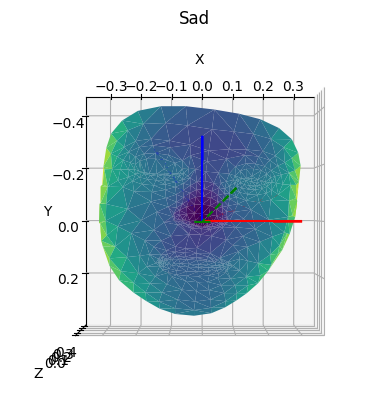

In [249]:
def rotate_mesh(mesh):
    mesh = re_pos(mesh)
    u,v,w = get_ref(mesh)
    x = np.array([1., 0., 0.])
    y = np.array([0., -1., 0.])
    z = np.array([0., 0., -1.])
    mesh = rot(mesh, u,v,w, x,y,z)
    ax = plt.figure().add_subplot(projection='3d')
    ax.set(title=label, xlabel='X', ylabel='Y', zlabel='Z')
    # ax.scatter3D(mesh[:, 0], mesh[:, 1], mesh[:, 2])
    ax.plot_trisurf(mesh[:, 0], mesh[:, 1], mesh[:, 2], cmap='viridis', edgecolor='none')
    ax = quiver_plot(ax, np.zeros(3), x, y, z)
    ax = quiver_plot(ax, np.zeros(3), u, v, w, dash=True)
    ax.view_init(270, 180, 90)
    # ax.view_init(320, 270, 0)

rotate_mesh(mesh)

In [150]:
%%timeit
rotate_mesh(mesh)

136 µs ± 327 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
